In [50]:
#Data import
import pandas as pd
macro = pd.read_pickle("Data/macro_us.pkl")
macro.index = macro.index.to_period('M')
ffc = pd.read_pickle("Data/df_us.pkl")

# Merge on date index (inner join ensures common dates only)
df = pd.concat([macro, ffc], axis=1, join='inner')
df.index = df.index.to_timestamp()

# Drop rows with missing values
df = df.dropna()

In [51]:
df.index.dtype

dtype('<M8[ns]')

  0%|          | 0/172 [00:00<?, ?it/s]/Users/justusschenk/Bachelorarbeit/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/justusschenk/Bachelorarbeit/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/justusschenk/Bachelorarbeit/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/justusschenk/Bachelorarbeit/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning

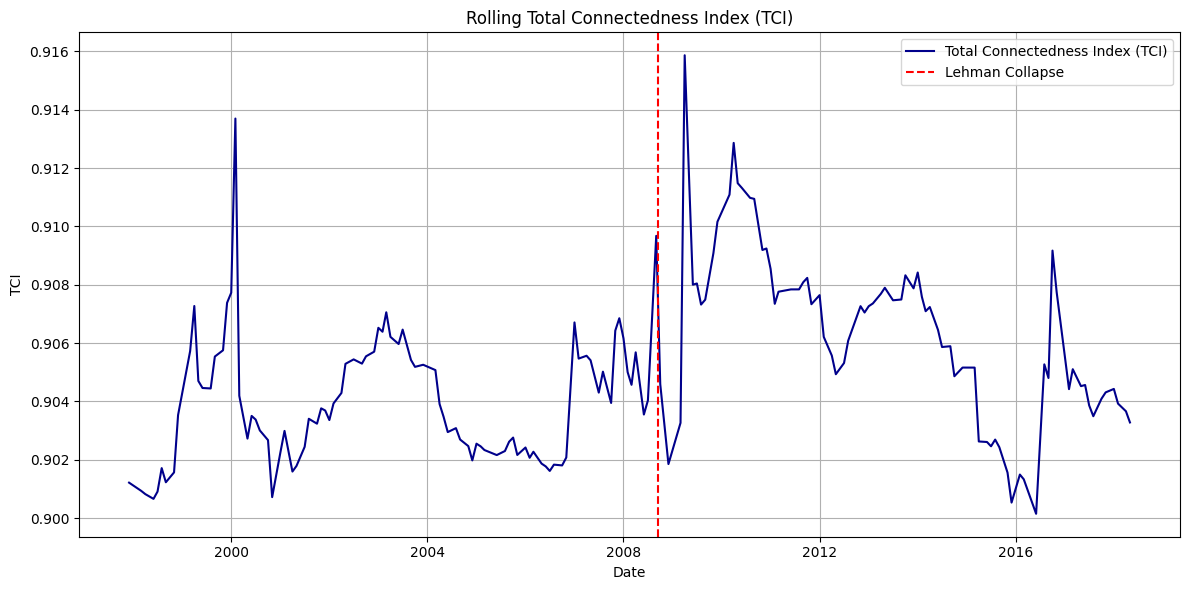

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from tqdm import tqdm  # Optional, for progress bar

# --- Parameters ---
window_size = 60           # Rolling window length (e.g., 60 months = 5 years)
fevd_horizon = 10          # Forecast horizon (e.g., 10 months)
maxlags = 1                # VAR lag order
date_index = df.index      # Assume df is your merged and cleaned dataset

# --- Output holder ---
tci_values = []
tci_dates = []

# --- Rolling window loop ---
for start in tqdm(range(len(df) - window_size + 1)):
    end = start + window_size
    window_data = df.iloc[start:end]

    try:
        model = VAR(window_data)
        results = model.fit(maxlags=maxlags)
        fevd = results.fevd(fevd_horizon)

        # Get FEVD matrix at selected horizon
        decomp = fevd.decomp[fevd_horizon - 1]  # (n x n), rows = affected, cols = shocks

        # Compute TCI: proportion of forecast variance from cross-variable shocks
        n = decomp.shape[0]
        off_diag_sum = decomp.sum() - np.trace(decomp)
        tci = off_diag_sum / n

        tci_values.append(tci)
        tci_dates.append(date_index[end - 1])  # align with last date in window

    except Exception as e:
        tci_values.append(np.nan)
        tci_dates.append(date_index[end - 1])
        print(f"Skipped window ending {date_index[end - 1].date()} due to error: {e}")

# --- Convert to Series ---
tci_series = pd.Series(tci_values, index=pd.to_datetime(tci_dates))

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(tci_series, label="Total Connectedness Index (TCI)", color="darkblue")
plt.axvline(pd.to_datetime("2008-09-15"), color="red", linestyle="--", label="Lehman Collapse")
plt.title("Rolling Total Connectedness Index (TCI)")
plt.xlabel("Date")
plt.ylabel("TCI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


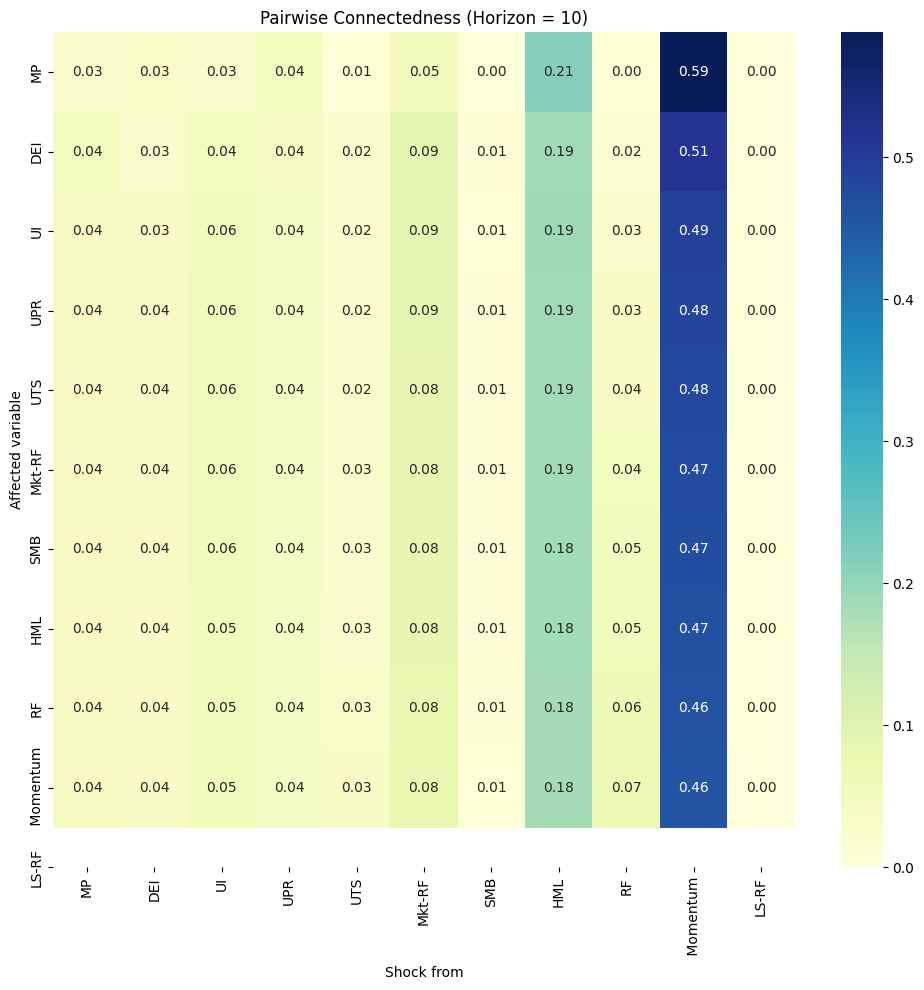

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Use latest decomposition from FEVD (decomp: [affected rows] x [shocking columns])
fevd_matrix = decomp  # Already from fevd.decomp[horizon-1]

labels = df.columns  # Variable names

plt.figure(figsize=(10, 10))
sns.heatmap(fevd_matrix, xticklabels=labels, yticklabels=labels,
            cmap="YlGnBu", annot=True, fmt=".2f")
plt.title(f"Pairwise Connectedness (Horizon = {fevd_horizon})")
plt.xlabel("Shock from")
plt.ylabel("Affected variable")
plt.tight_layout()
plt.show()


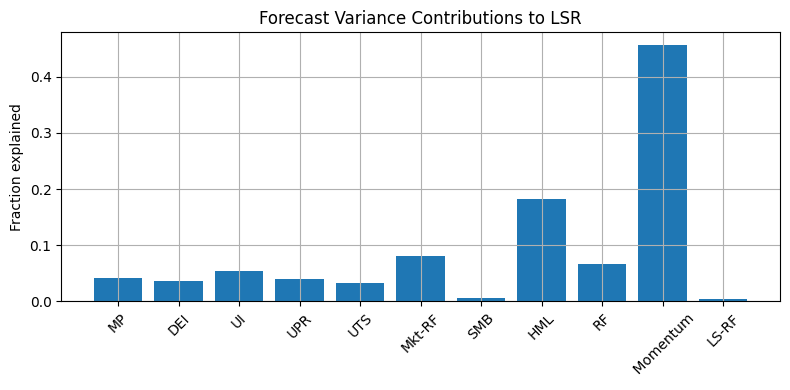

In [67]:
target_idx = df.columns.get_loc("LS-RF")
contributions = fevd_matrix[target_idx-1]

plt.figure(figsize=(8, 4))
plt.bar(df.columns, contributions)
plt.title("Forecast Variance Contributions to LSR")
plt.ylabel("Fraction explained")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

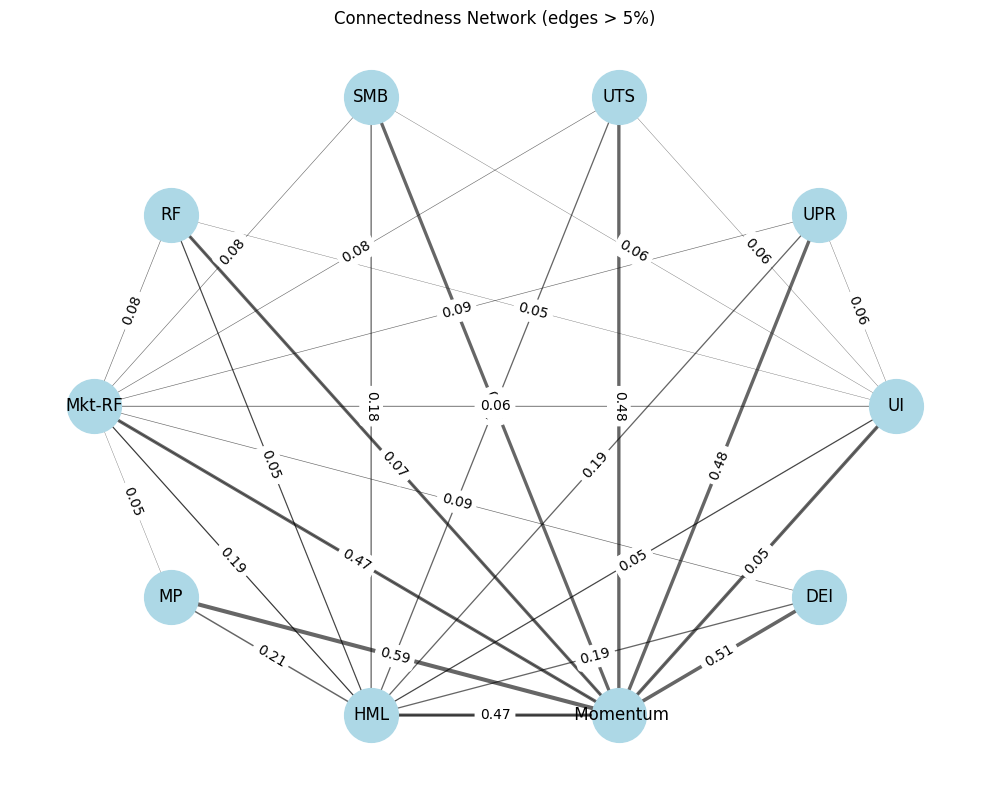

In [62]:
import networkx as nx

G = nx.DiGraph()

# Threshold to show only strong connections
threshold = 0.05  # Only show connections >5%
n = fevd_matrix.shape[0]
labels = df.columns

# Add edges based on connectedness
for i in range(n):
    for j in range(n):
        if i != j and fevd_matrix[i, j] > threshold:
            G.add_edge(labels[j], labels[i], weight=fevd_matrix[i, j])

# Draw the graph
pos = nx.shell_layout(G)
edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_size=1500, node_color='lightblue')
nx.draw_networkx_labels(G, pos, font_size=12)
nx.draw_networkx_edges(G, pos, edgelist=edges, width=5*np.array(weights), alpha=0.6)
nx.draw_networkx_edge_labels(G, pos,
    edge_labels={(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)})

plt.title("Connectedness Network (edges > 5%)")
plt.axis('off')
plt.tight_layout()
plt.show()
